This notebook will perform image regression on a folder of images and labels from a .csv file

In [1]:
from fastai.vision.all import *

In [6]:
# path to base folder 
path = Path('/mnt/2TB Working/Projects/Otoliths/v2')
# image folder path
image_path = path/'500px images'
# label csv path
label_path = path/'ages for nick.csv'

In [7]:
# batch size this is limited by the GPU memory
batch_size = 20
# size of your images
img_size = 500
# your desired model type, probibly one of these resnet18, resnet34, resnet50, resnet101, resnet152
model_type = resnet18

In [8]:
# get a list of image file names
image_paths = get_image_files(image_path)
file_names = []
for i in image_paths:
    file_names.append(os.path.basename(i))

In [9]:
# open the label file are a pandas dataframe and filter it by the image list
labels = pd.read_csv(label_path)
labels = labels[labels['Image_name'].isin(file_names)]
labels.head()

,Image_name,Age
1,AH13-2352.jpg,4.83
4,AH13-0507.jpg,4.92
6,AH11-0776.jpg,4.75
10,AH13-2227.jpg,4.83
11,AH12-1818.jpg,4.75


In [10]:
item_tfms = []#Resize(img_size)
batch_tfms = [*aug_transforms(size=img_size, max_rotate=10.0,max_warp=0),Normalize.from_stats(*imagenet_stats)]

In [11]:
# make a fastai databunch using the labels and the images, also apply some augmentations 
# https://docs.fast.ai/vision.augment.html#aug_transforms
data = ImageDataLoaders.from_df(df = labels, path = image_path, seed = 42, 
                                bs = batch_size,y_block = RegressionBlock,
                                batch_tfms = batch_tfms,
                                item_tfms = item_tfms
                               )

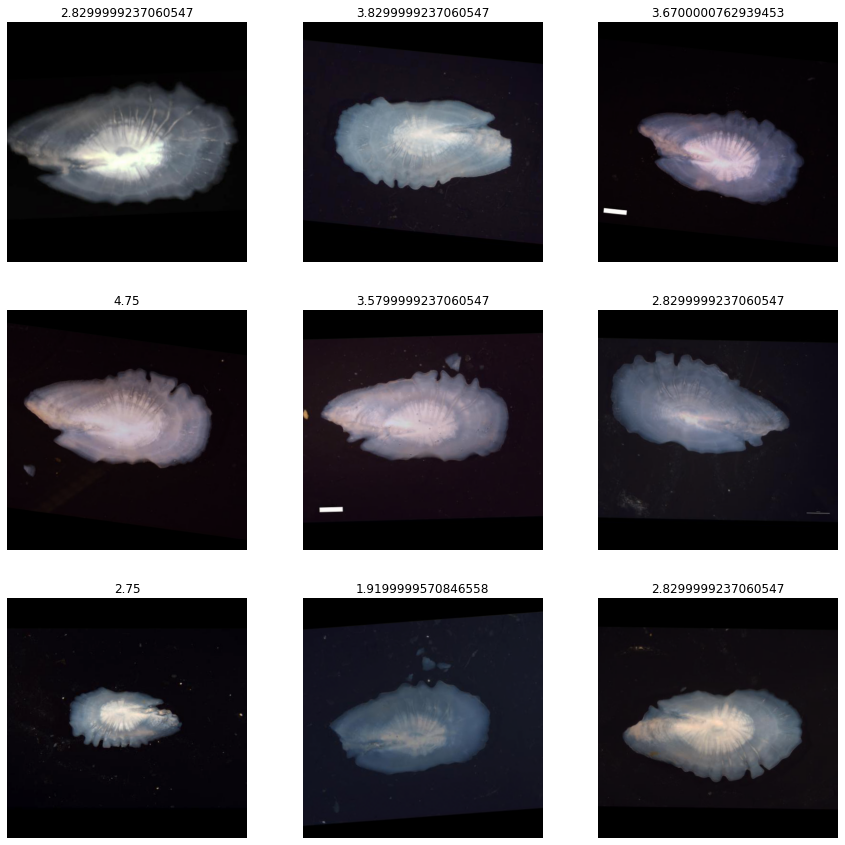

In [12]:
# show some data
data.show_batch(max_n = 9, figsize = (15,15))

In [13]:
# define an easily understandable metric
def mean_abs_error(pred,targ):
    "Mean absolute error between `pred` and `targ`."
    pred,targ = flatten_check(pred,targ)
    return torch.abs(pred - targ).mean()

In [14]:
# make function to define a learner to reduce code repetition  
def learner():
    learn = cnn_learner(data, resnet18, metrics = mean_abs_error).to_fp16()
    return learn
learn = learner()

SuggestedLRs(valley=0.0020892962347716093)

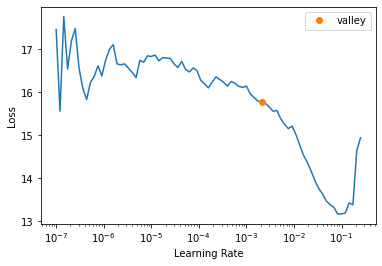

In [15]:
# plot graph to afind a reasonable LR
learn.lr_find()

In [16]:
#  picking the correct LR is hard, so instead select a range and will will try a bunch of differnt LRs
start = 10**-2
stop = 10**-1.3
# how many differnt LRs to try
steps = 4 # dont know why but if this is larger than 4 the loop will throw an error...
# epocs of each LR
freeze_epocs = 5
unfreeze_epocs = 15
# a version number to avoid overwriting an older model
version = str(1.25)
LR_range = np.geomspace(start, stop, steps)
print(LR_range)

[0.01       0.01711328 0.02928645 0.05011872]


In [17]:
# try each learning rate
for lr in LR_range:
    print('Trying a learning rate of',lr)
#     make filename
    file_name = model_type.__name__+'_'+str(img_size)+'px_v'+version+'_LR_'+str(np.where(LR_range == lr)[0][0]+1)
    print(file_name)
#     set up a new learner
    learn = learner()
#     run model
    learn.fine_tune(epochs = unfreeze_epocs,base_lr = lr, freeze_epochs = freeze_epocs, 
                    cbs = SaveModelCallback(monitor='mean_abs_error', fname=file_name))
    # https://github.com/fastai/fastai/blob/master/fastai/callback/tracker.py

#     learn.fine_tune(epocs,lr)
#     learn.save(file_name)
#     learn.export('models/'+file_name+'.pkl')


Trying a learning rate of 0.01
resnet18_500px_v1.25_LR_1


epoch,train_loss,valid_loss,mean_abs_error,time
0,6.454127,2.464966,1.247609,00:18
1,2.274718,0.933630,0.738138,00:17


Better model found at epoch 0 with mean_abs_error value: 1.2476085424423218.
Better model found at epoch 1 with mean_abs_error value: 0.7381376624107361.


KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle(epocs)

In [18]:
# you may need to reset the notebook to make this work
best_model_name = 'resnet18_500px_v1.24_LR_3'
learn = learner()
learn.load(best_model_name)#.to_fp16()

/home/nick/fastai/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


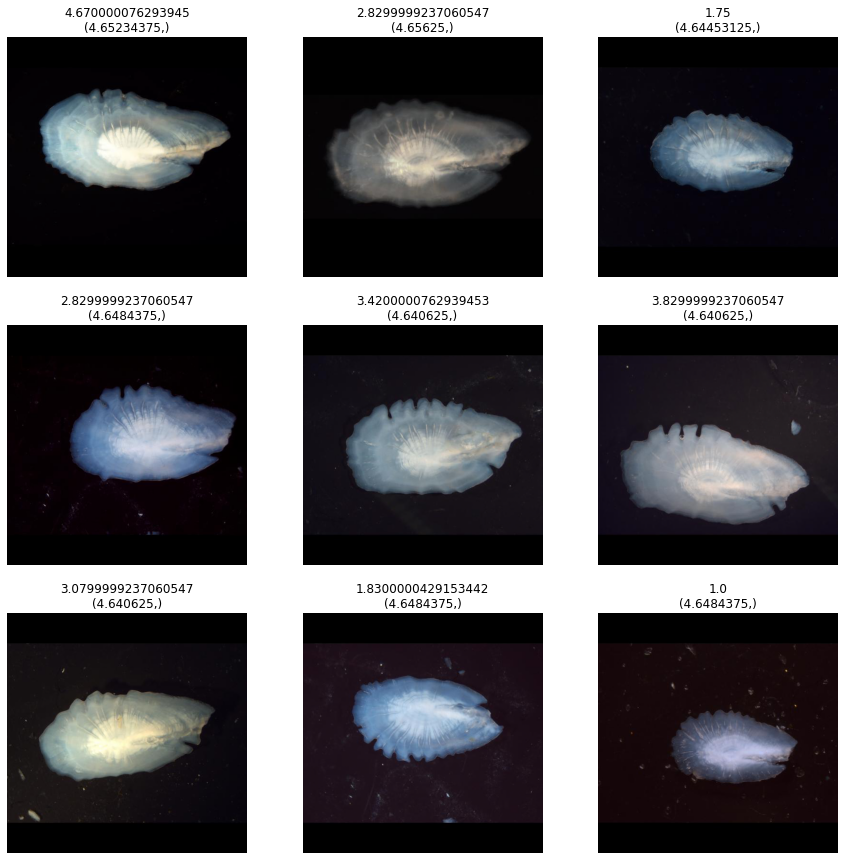

In [19]:
learn.show_results(max_n = 9, figsize = (15,15))